# Ames Housing Prices — Batch Learning Workflow and Inflation Trend Analysis

**Aim.** This notebook implements a complete **batch learning** workflow for the Ames Housing dataset to predict `SalePrice` and to explore inflation-like price trends. The analysis includes data loading, targeted missing-value imputation, feature selection for temporal trend analysis, univariate and bivariate EDA, correlation analysis, model building (Decision Tree, Random Forest, custom Ridge Regression from scratch, and Gradient Boosting), and final evaluation.

**Learning mode choice.** Since the dataset is not streamed in real time, **online learning** is not feasible in this environment. However, the presence of temporal variables (`Yr.Sold`, `Mo.Sold`) enables the use of **batch-mode inflation trend analysis**, quantifying price drift and seasonality retrospectively.

---

## 1. Importing Necessary Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from scipy.stats import linregress
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

## 2. Data Loading and Initial Inspection

In [2]:
# Load the Ames Housing dataset
file_path = r"C:\Users\Owner\Desktop\RH Project\ames.csv"
df = pd.read_csv(file_path)

In [3]:
df.head()

,Order,PID,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
df.shape

(2930, 82)

In [5]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS.SubClass      2930 non-null   int64  
 3   MS.Zoning        2930 non-null   object 
 4   Lot.Frontage     2440 non-null   float64
 5   Lot.Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot.Shape        2930 non-null   object 
 9   Land.Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot.Config       2930 non-null   object 
 12  Land.Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition.1      2930 non-null   object 
 15  Condition.2      2930 non-null   object 
 16  Bldg.Type        2930 non-null   object 
 17  

## 3. Missing-Value Handling

In [6]:
print("\nMissing Values:")
missing = df.isnull().sum()
missing = missing[missing > 0]
print(missing if not missing.empty else "No missing values detected.")  



Missing Values:
Lot.Frontage       490
Alley             2732
Mas.Vnr.Type      1775
Mas.Vnr.Area        23
Bsmt.Qual           80
Bsmt.Cond           80
Bsmt.Exposure       83
BsmtFin.Type.1      80
BsmtFin.SF.1         1
BsmtFin.Type.2      81
BsmtFin.SF.2         1
Bsmt.Unf.SF          1
Total.Bsmt.SF        1
Electrical           1
Bsmt.Full.Bath       2
Bsmt.Half.Bath       2
Fireplace.Qu      1422
Garage.Type        157
Garage.Yr.Blt      159
Garage.Finish      159
Garage.Cars          1
Garage.Area          1
Garage.Qual        159
Garage.Cond        159
Pool.QC           2917
Fence             2358
Misc.Feature      2824
dtype: int64


In [7]:
# 6. Impute Missing Values
# Fill NAs where NA means "none" (string/categorical columns)
none_cols = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu',
             'GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature','MasVnrType']
for col in none_cols:
    if col in df.columns:
        df[col] = df[col].fillna("None")

# Fill numerical columns where NA means "0"
zero_cols = ['GarageYrBlt','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
             'TotalBsmtSF','BsmtFullBath','BsmtHalfBath','MasVnrArea']
for col in zero_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# LotFrontage: Impute by neighborhood median
if 'LotFrontage' in df.columns:
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median())
    )

# The rest: fill categorical with mode, numerical with median
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())

print(df.isnull().sum().sum(), "missing values left.")

0 missing values left.


After imputation, **no missing values remain**.

## 4.Feature Selection for Inflation Trends
Although the dataset has 80 features, **only a targeted subset** is required for temporal trend estimation and downstream modeling.  
For **inflation trend analysis**, priority is choosen based on correlation analysis:

In [8]:
# Select numerical columns (excluding Id) for correlation analysis
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('PID')
df_numeric = df[numerical_cols].copy()

# Handle missing values in numerical features (impute with mean)
df_numeric = df_numeric.fillna(df_numeric.mean())

# Select categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
df_categorical = df[categorical_cols].copy()

# Encode categorical features using one-hot encoding
# Drop first category to avoid multicollinearity, handle missing values by filling with 'Missing'
df_encoded = pd.get_dummies(df_categorical, drop_first=True, dummy_na=True)

# Combine numerical and encoded categorical features
df_combined = pd.concat([df_numeric, df_encoded], axis=1)



In [9]:
# Calculate correlation matrix for all features with SalePrice
corr_matrix = df_combined.corr()
saleprice_corr = corr_matrix['SalePrice'].sort_values(ascending=False).round(2)


In [10]:
# Select highly correlated features (|r| >= 0.5)
highly_correlated = saleprice_corr[abs(saleprice_corr) >= 0.5].index.tolist()
print("\nHighly Correlated Features with SalePrice (|r| >= 0.5):")
print(saleprice_corr[highly_correlated])


Highly Correlated Features with SalePrice (|r| >= 0.5):
SalePrice            1.00
Overall.Qual         0.80
Gr.Liv.Area          0.71
Garage.Cars          0.65
Garage.Area          0.64
Total.Bsmt.SF        0.63
X1st.Flr.SF          0.62
Year.Built           0.56
Full.Bath            0.55
Year.Remod.Add       0.53
Foundation_PConc     0.52
Garage.Yr.Blt        0.51
Mas.Vnr.Area         0.50
TotRms.AbvGrd        0.50
Bsmt.Qual_TA        -0.50
Garage.Finish_Unf   -0.52
Kitchen.Qual_TA     -0.53
Exter.Qual_TA       -0.59
Name: SalePrice, dtype: float64


In [11]:
# Select highly correlated features (|r| >= 0.5) based on provided output
selected_features = [
    'SalePrice',  # Target for prediction
    'Overall.Qual',  # r=0.80, top predictor, house quality
    'Gr.Liv.Area',  # r=0.71, living space size
    'Garage.Cars',  # r=0.65, parking capacity, low missingness (0.14%)
    'Garage.Area',  # r=0.64, garage size, but redundant with Garage.Cars
    'Total.Bsmt.SF',  # r=0.63, basement size, 0.03% missing
    'X1st.Flr.SF',  # r=0.62, main living area
    'Year.Built',  # r=0.56, house age for inflation
    'Full.Bath',  # r=0.55, key amenity, no missing
    'TotRms.AbvGrd',  # r=0.50, room count, no missing
    'Year.Remod.Add',  # r=0.53, remodel year for trends
    'Foundation_PConc',  # r=0.52, categorical, concrete foundation
    'Garage.Yr.Blt',  # r=0.51, garage age, 5.4% missing
    'Mas.Vnr.Area',  # r=0.50, masonry veneer area, 0.8% missing
    'Bsmt.Qual_TA',  # r=-0.50, categorical, typical basement quality
    'Garage.Finish_Unf',  # r=-0.52, categorical, unfinished garage
    'Kitchen.Qual_TA',  # r=-0.53, categorical, typical kitchen quality
    'Exter.Qual_TA'  # r=-0.59, categorical, typical exterior quality
]

In [12]:
df_combined.head()

,Order,MS.SubClass,Lot.Frontage,Lot.Area,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Mas.Vnr.Area,BsmtFin.SF.1,...,Sale.Type_Oth,Sale.Type_VWD,Sale.Type_WD,Sale.Type_nan,Sale.Condition_AdjLand,Sale.Condition_Alloca,Sale.Condition_Family,Sale.Condition_Normal,Sale.Condition_Partial,Sale.Condition_nan
0,1,20,141.0,31770,6,5,1960,1960,112.0,639.0,...,False,False,True,False,False,False,False,True,False,False
1,2,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,False,False,True,False,False,False,False,True,False,False
2,3,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,False,False,True,False,False,False,False,True,False,False
3,4,20,93.0,11160,7,5,1968,1968,0.0,1065.0,...,False,False,True,False,False,False,False,True,False,False
4,5,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,False,False,True,False,False,False,False,True,False,False


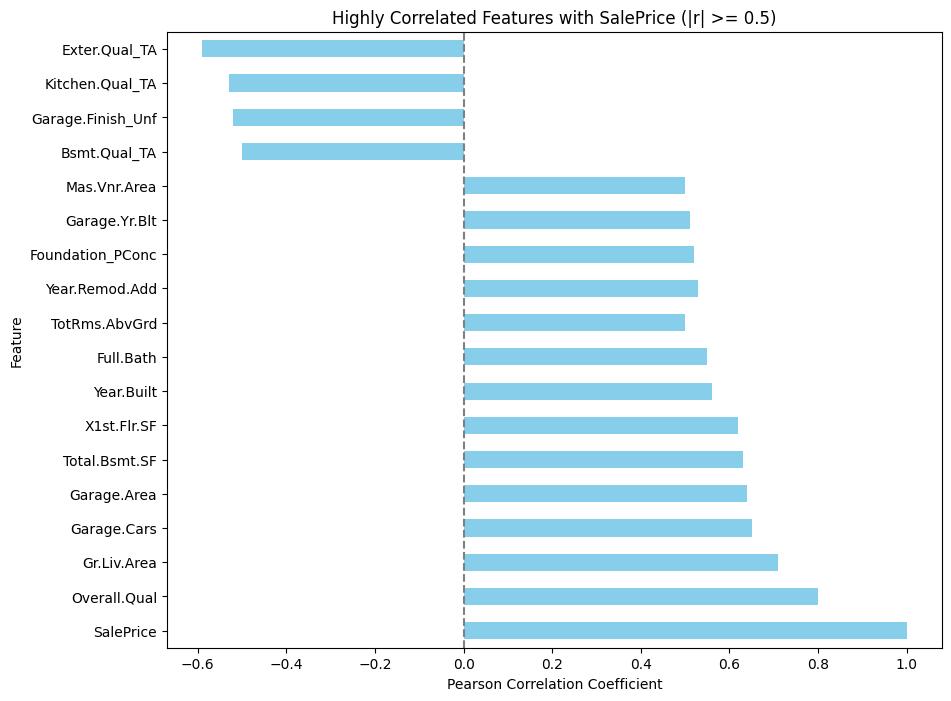

In [13]:
# Visualize correlations for highly correlated features
plt.figure(figsize=(10, 8))
saleprice_corr[selected_features].plot(kind='barh', color='skyblue')
plt.title('Highly Correlated Features with SalePrice (|r| >= 0.5)')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Feature')
plt.axvline(x=0, color='gray', linestyle='--')
plt.show()

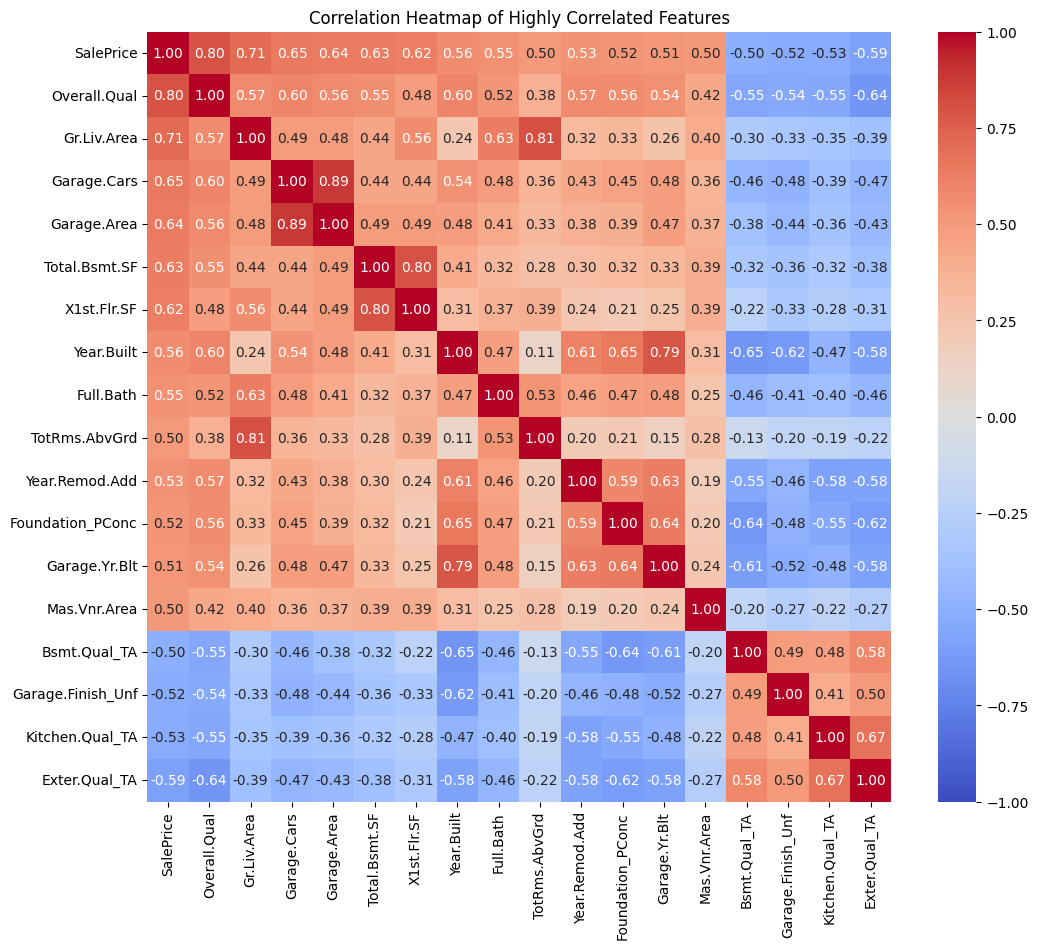

In [14]:
# Correlation heatmap for selected features
plt.figure(figsize=(12, 10))
sns.heatmap(df_combined[selected_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Heatmap of Highly Correlated Features')
plt.show()

## 5. Univariate Analysis

**5.1. Target Variable — `SalePrice`.**  
A histogram with KDE is used to

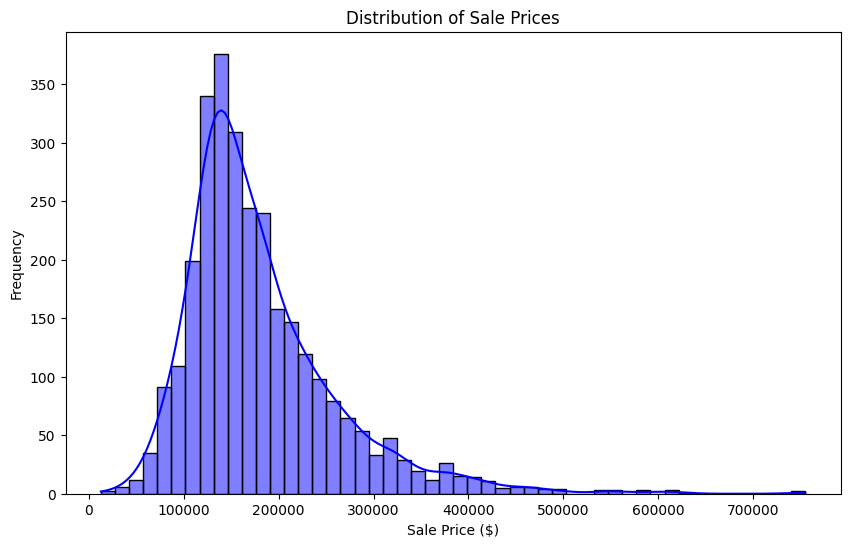

In [15]:
# Price distribution Target Variable Check
plt.figure(figsize=(10, 6))
sns.histplot(df_combined['SalePrice'], bins=50, kde=True, color='blue')
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price ($)')
plt.ylabel('Frequency')
plt.show()



**5.2. Key Predictors.**  
Distributions are plotted for:

In [16]:
# Separate numeric and categorical features from the selected_features list
predictor_features = [f for f in selected_features if f != 'SalePrice']
numeric_feats = df_combined[predictor_features].select_dtypes(include=['int64', 'float64']).columns
categorical_feats = [f for f in predictor_features if f not in numeric_feats]


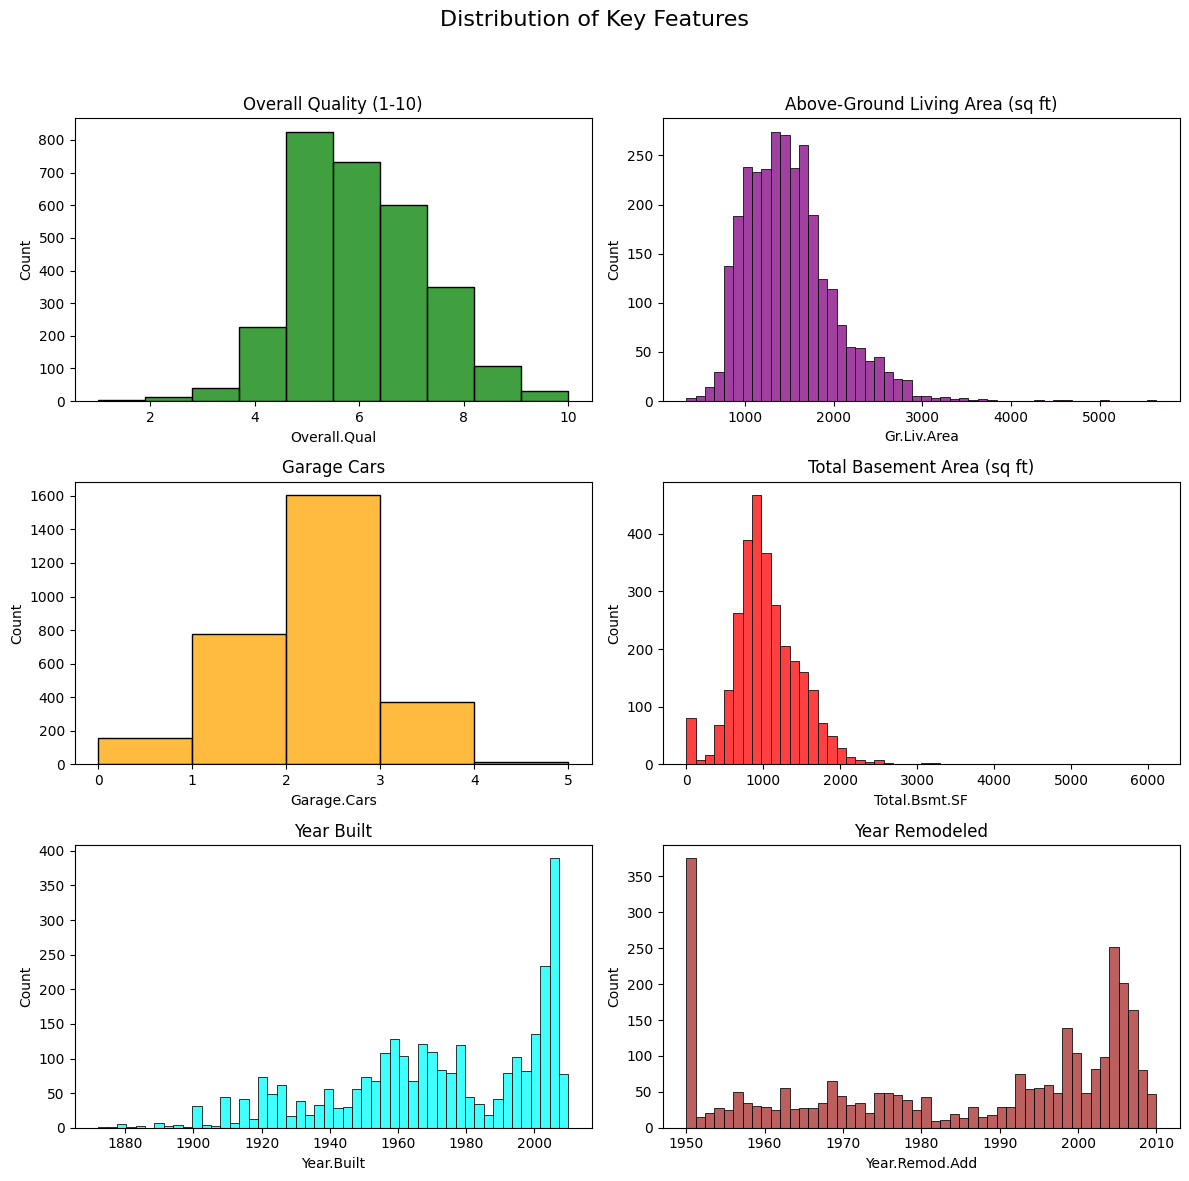

In [17]:
# Feature distributions
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Distribution of Key Features', fontsize=16)
sns.histplot(df_combined['Overall.Qual'], bins=10, ax=axes[0, 0], color='green')
axes[0, 0].set_title('Overall Quality (1-10)')
sns.histplot(df_combined['Gr.Liv.Area'], bins=50, ax=axes[0, 1], color='purple')
axes[0, 1].set_title('Above-Ground Living Area (sq ft)')
sns.histplot(df_combined['Garage.Cars'], bins=5, ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Garage Cars')
sns.histplot(df_combined['Total.Bsmt.SF'], bins=50, ax=axes[1, 1], color='red')
axes[1, 1].set_title('Total Basement Area (sq ft)')
sns.histplot(df_combined['Year.Built'], bins=50, ax=axes[2, 0], color='cyan')
axes[2, 0].set_title('Year Built')
sns.histplot(df_combined['Year.Remod.Add'], bins=50, ax=axes[2, 1], color='brown')
axes[2, 1].set_title('Year Remodeled')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




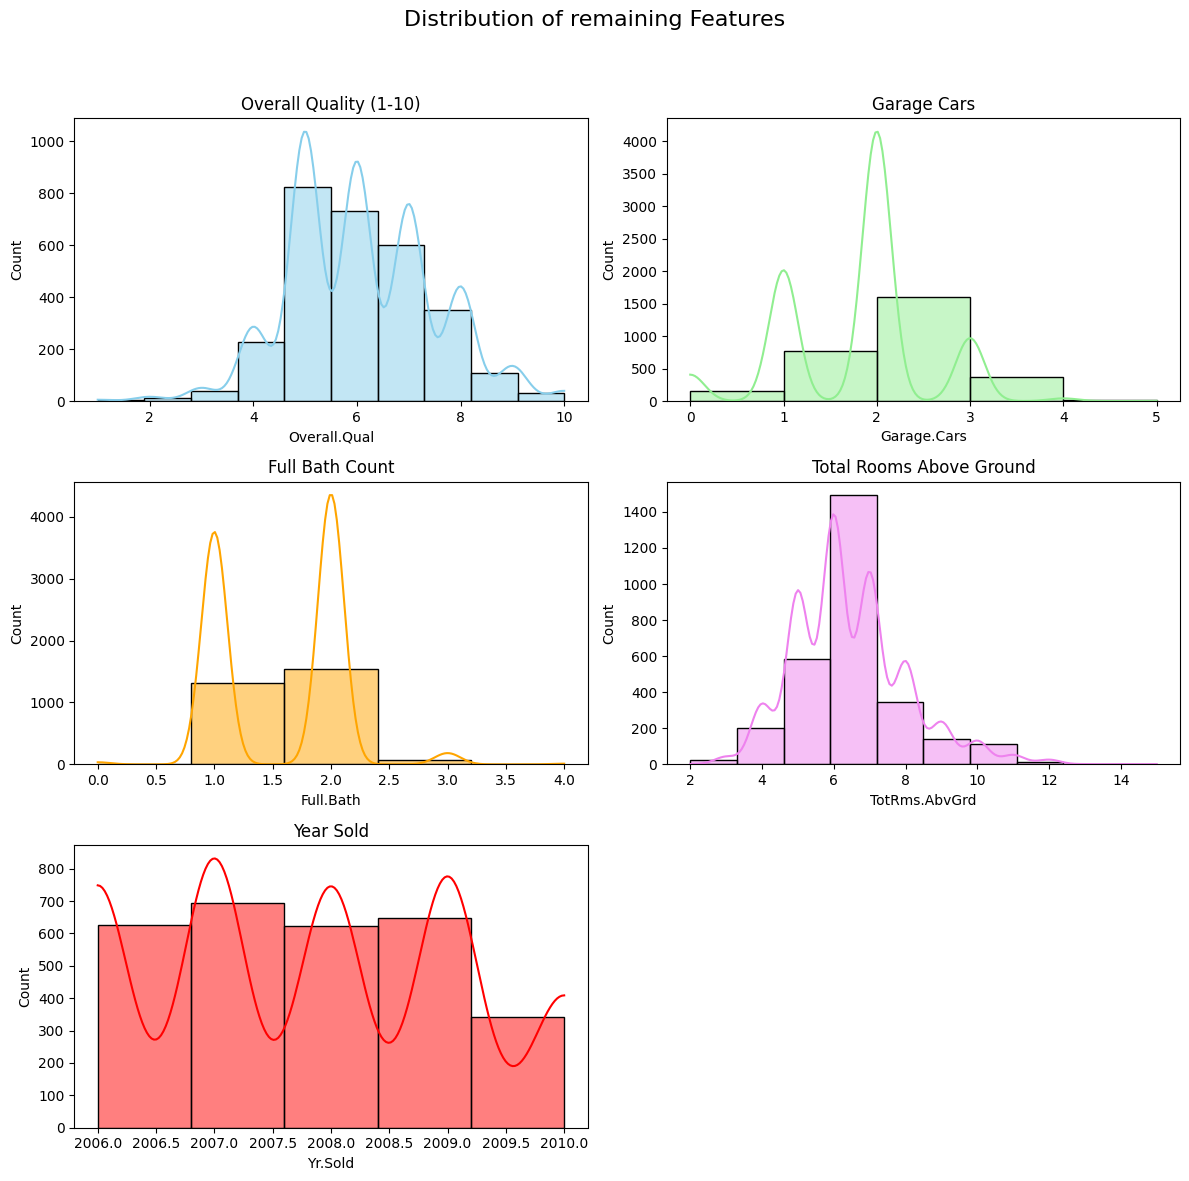

In [18]:
# Distribution of selected key features (5 variables)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Distribution of remaining Features', fontsize=16)

# Overall Quality
sns.histplot(df_combined['Overall.Qual'], bins=10, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Overall Quality (1-10)')

# Garage Cars
sns.histplot(df_combined['Garage.Cars'], bins=5, kde=True, ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Garage Cars')

# Full Bath
sns.histplot(df_combined['Full.Bath'], bins=5, kde=True, ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Full Bath Count')

# Total Rooms Above Ground
sns.histplot(df_combined['TotRms.AbvGrd'], bins=10, kde=True, ax=axes[1, 1], color='violet')
axes[1, 1].set_title('Total Rooms Above Ground')

# Year Sold
sns.histplot(df['Yr.Sold'], bins=len(df['Yr.Sold'].unique()), kde=True, ax=axes[2, 0], color='red')
axes[2, 0].set_title('Year Sold')

# Remove empty subplot (bottom right)
axes[2, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


categorical Features

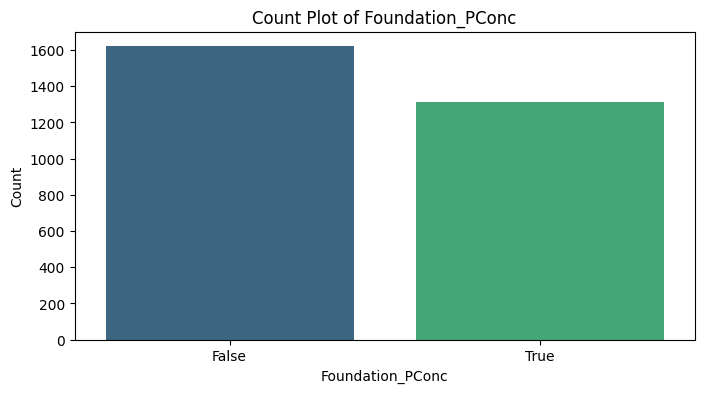

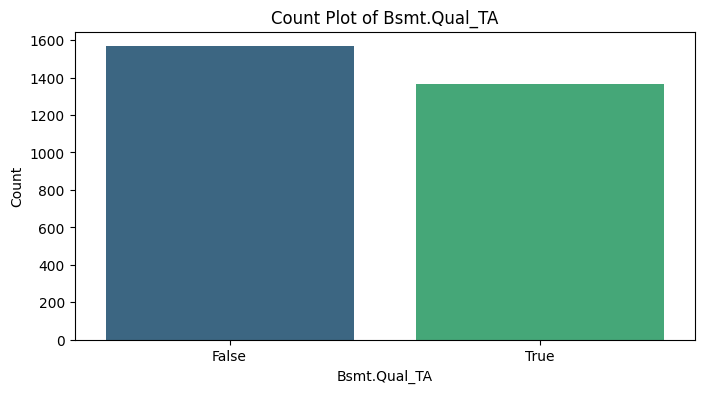

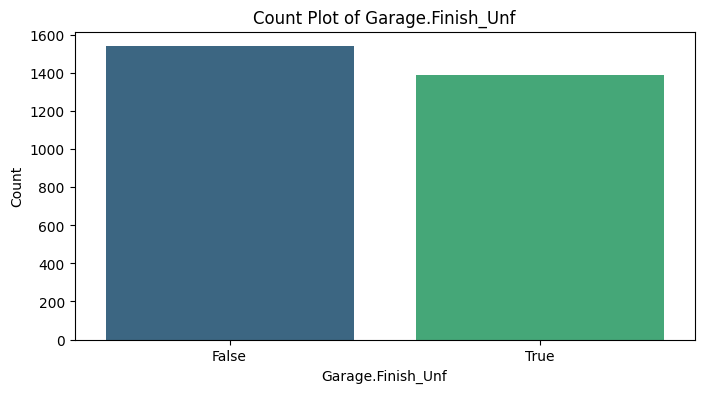

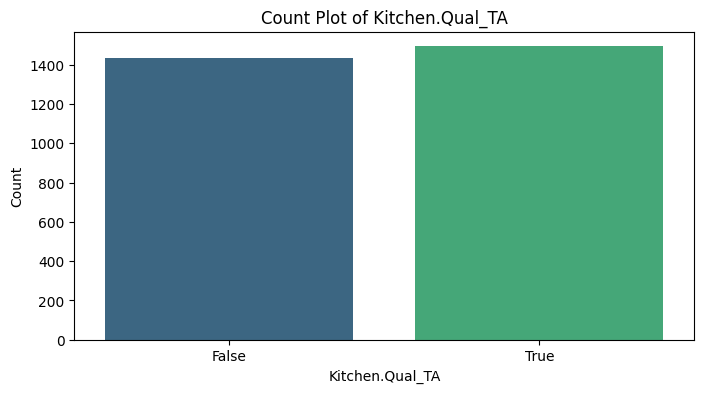

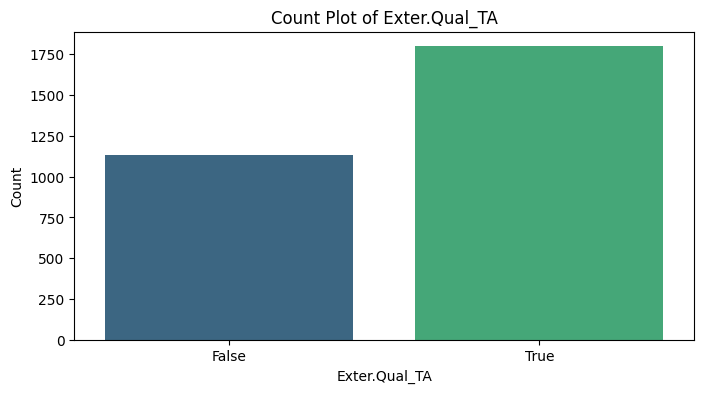

In [19]:
for col in categorical_feats:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df_combined, x=col, palette='viridis')
    plt.title(f"Count Plot of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


## 6. Bivariate Analysis

**6.1. Scatterplots vs. `SalePrice`.**  
Scatterplots are generated for `SalePrice` against top predictors (`Overall.Qual`, `Gr.Liv.Area`, `Garage.Cars`, `Total.Bsmt.SF`) to visualize direct associations and detect non-linear trends.

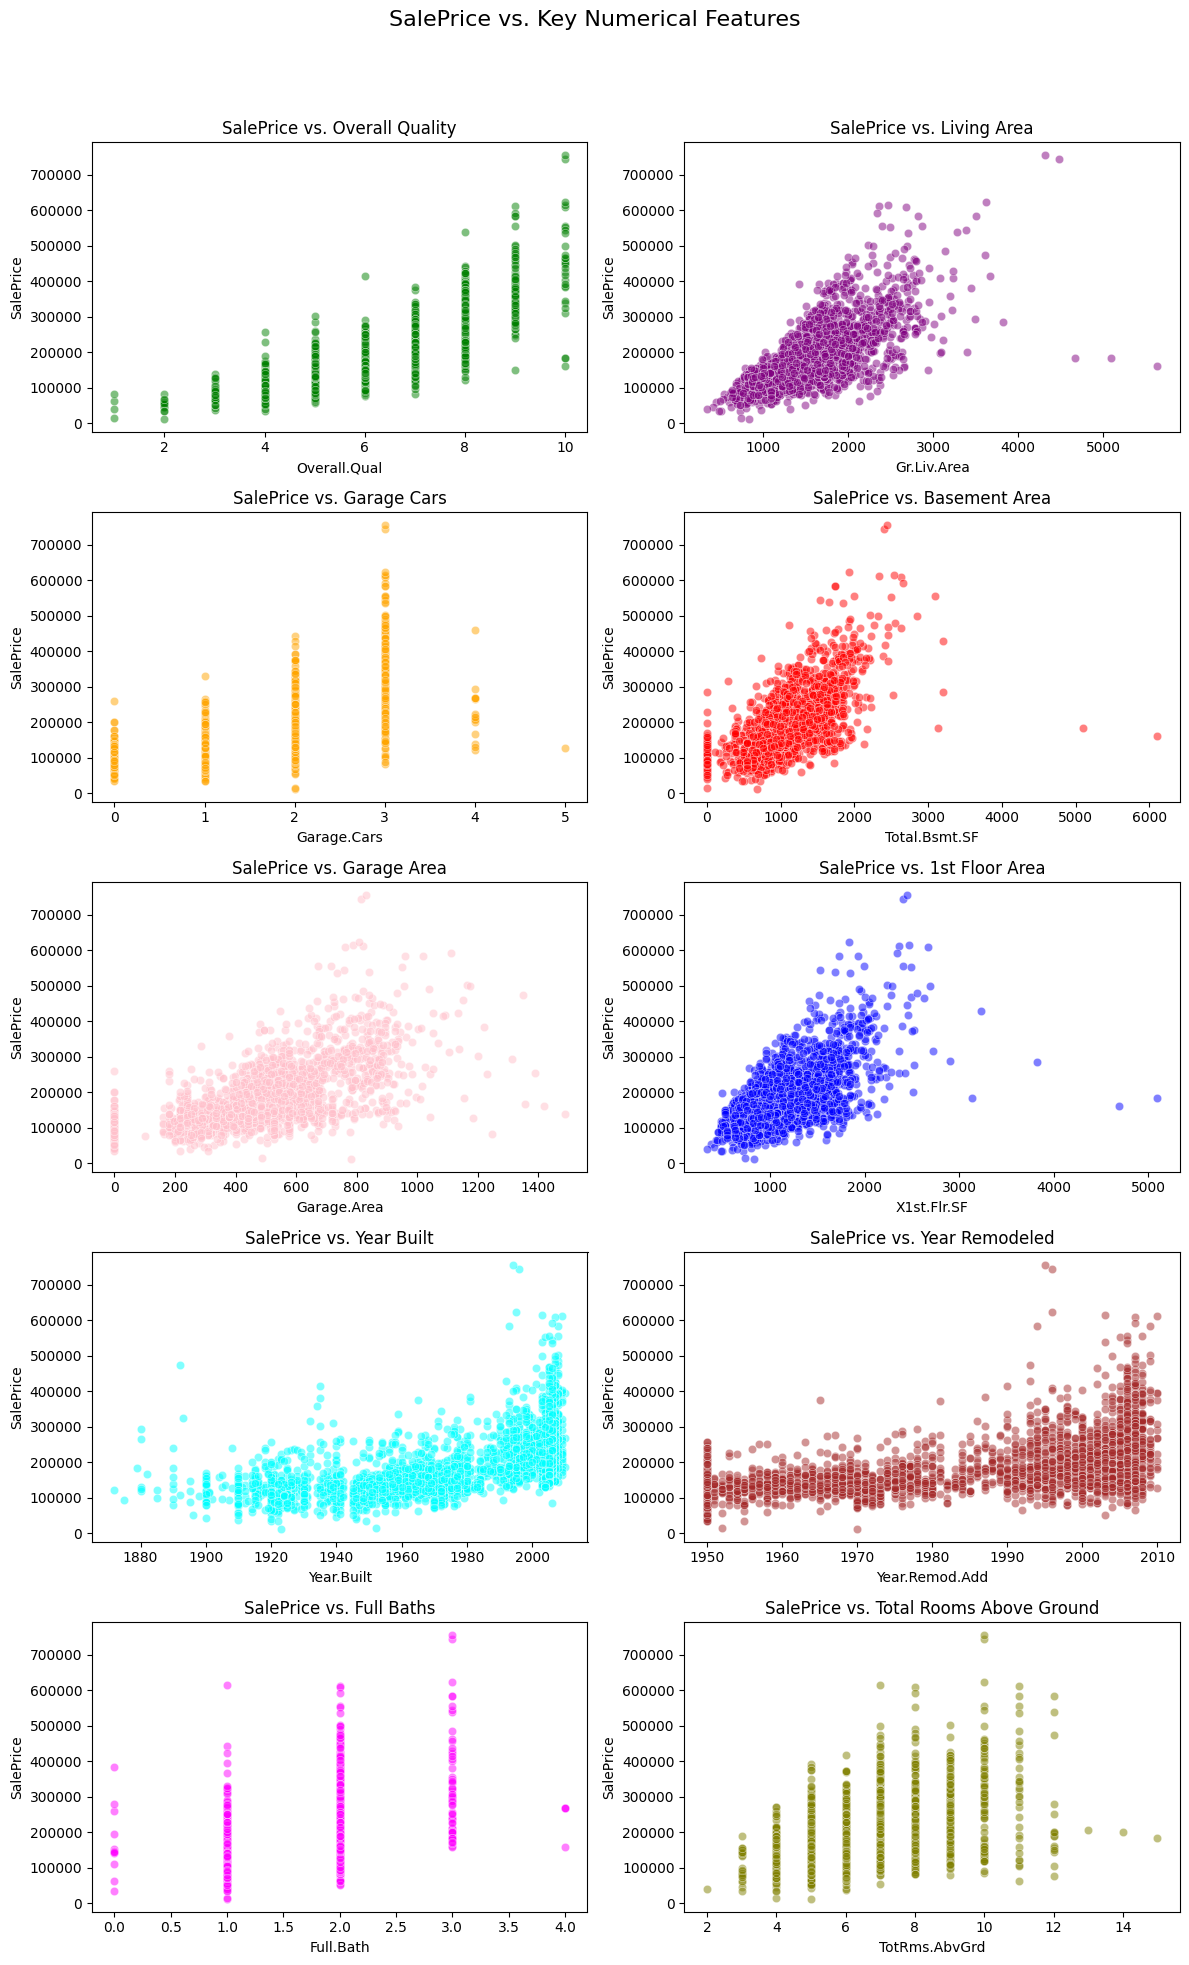

In [20]:
# Scatter plots for selected numerical features vs. SalePrice
fig, axes = plt.subplots(5, 2, figsize=(12, 20))
fig.suptitle('SalePrice vs. Key Numerical Features', fontsize=16)

# Row 1
sns.scatterplot(x=df_combined['Overall.Qual'], y=df_combined['SalePrice'], ax=axes[0, 0], color='green', alpha=0.5)
axes[0, 0].set_title('SalePrice vs. Overall Quality')

sns.scatterplot(x=df_combined['Gr.Liv.Area'], y=df_combined['SalePrice'], ax=axes[0, 1], color='purple', alpha=0.5)
axes[0, 1].set_title('SalePrice vs. Living Area')

# Row 2
sns.scatterplot(x=df_combined['Garage.Cars'], y=df_combined['SalePrice'], ax=axes[1, 0], color='orange', alpha=0.5)
axes[1, 0].set_title('SalePrice vs. Garage Cars')

sns.scatterplot(x=df_combined['Total.Bsmt.SF'], y=df_combined['SalePrice'], ax=axes[1, 1], color='red', alpha=0.5)
axes[1, 1].set_title('SalePrice vs. Basement Area')

# Row 3
sns.scatterplot(x=df_combined['Garage.Area'], y=df_combined['SalePrice'], ax=axes[2, 0], color='pink', alpha=0.5)
axes[2, 0].set_title('SalePrice vs. Garage Area')

sns.scatterplot(x=df_combined['X1st.Flr.SF'], y=df_combined['SalePrice'], ax=axes[2, 1], color='blue', alpha=0.5)
axes[2, 1].set_title('SalePrice vs. 1st Floor Area')

# Row 4
sns.scatterplot(x=df_combined['Year.Built'], y=df_combined['SalePrice'], ax=axes[3, 0], color='cyan', alpha=0.5)
axes[3, 0].set_title('SalePrice vs. Year Built')

sns.scatterplot(x=df_combined['Year.Remod.Add'], y=df_combined['SalePrice'], ax=axes[3, 1], color='brown', alpha=0.5)
axes[3, 1].set_title('SalePrice vs. Year Remodeled')

# Row 5
sns.scatterplot(x=df_combined['Full.Bath'], y=df_combined['SalePrice'], ax=axes[4, 0], color='magenta', alpha=0.5)
axes[4, 0].set_title('SalePrice vs. Full Baths')

sns.scatterplot(x=df_combined['TotRms.AbvGrd'], y=df_combined['SalePrice'], ax=axes[4, 1], color='olive', alpha=0.5)
axes[4, 1].set_title('SalePrice vs. Total Rooms Above Ground')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**6.2. Group-wise Comparisons.**  
A boxplot of `SalePrice` by `Yr.Sold` shows price differences across years, supporting the initial investigation into inflation patterns.



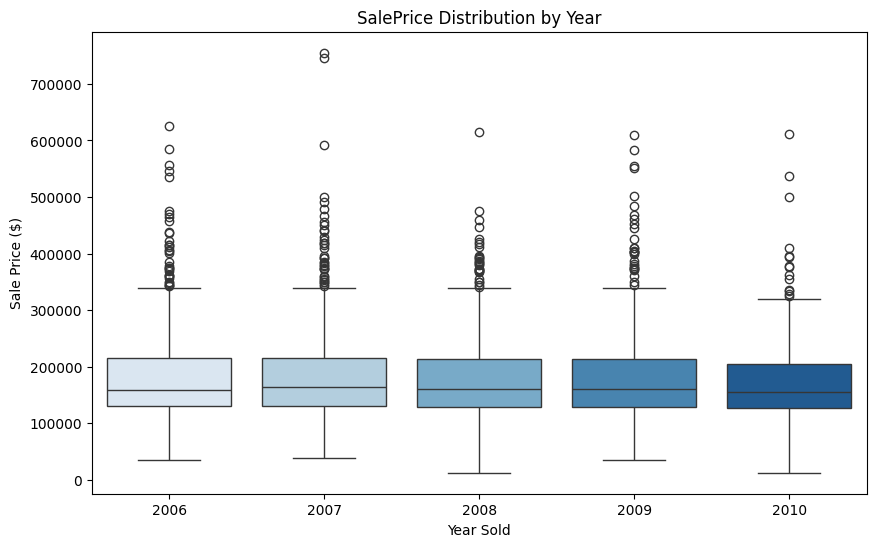

In [21]:
# Boxplot of SalePrice by Year
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_combined['Yr.Sold'], y=df_combined['SalePrice'], palette='Blues')
plt.title('SalePrice Distribution by Year')
plt.xlabel('Year Sold')
plt.ylabel('Sale Price ($)')
plt.show()

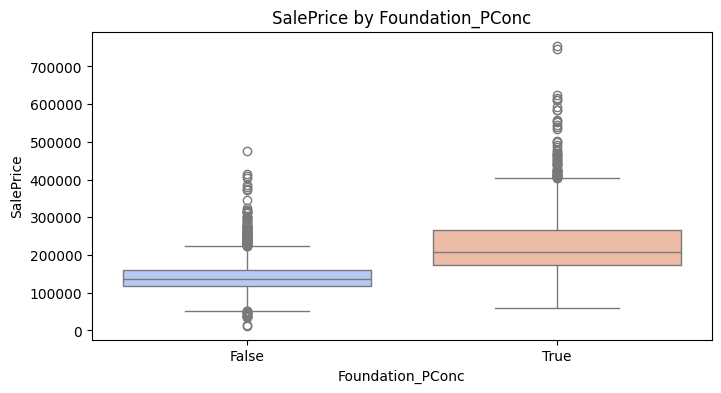

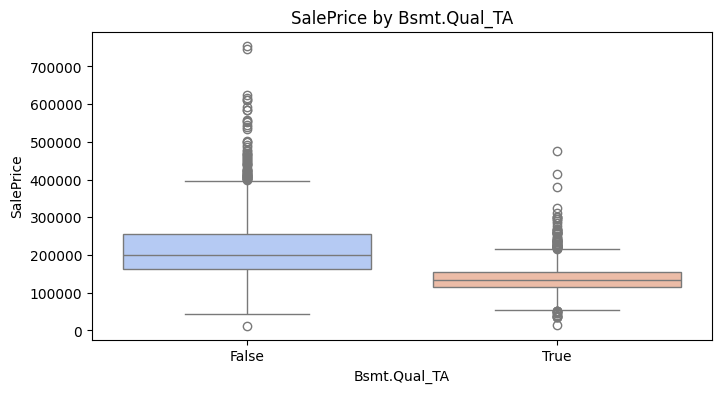

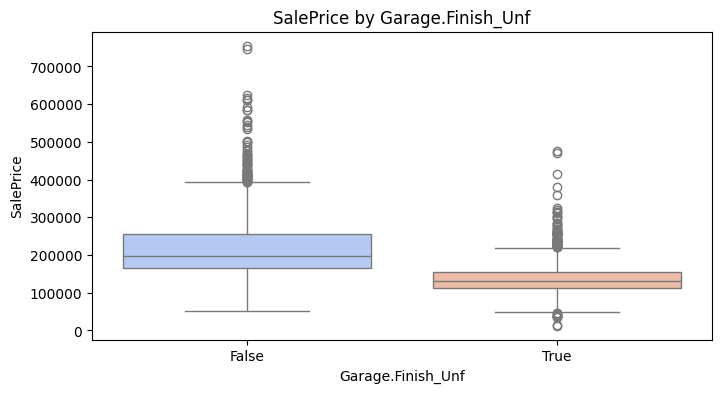

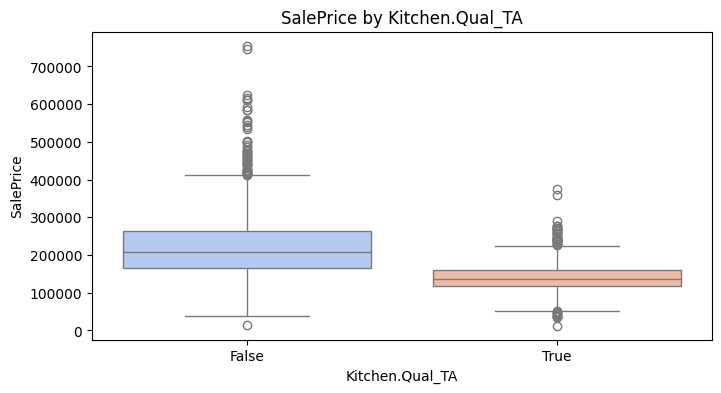

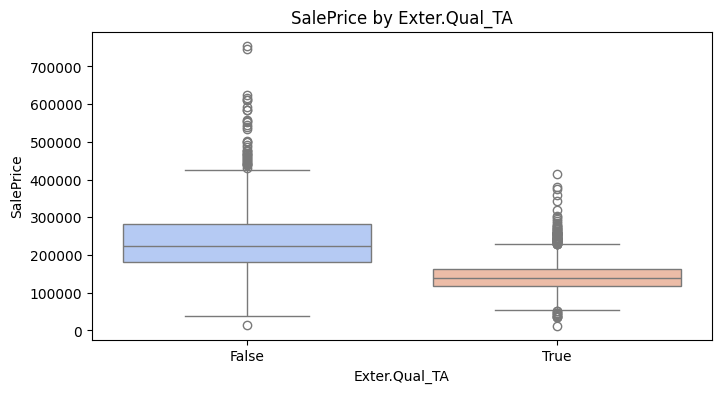

In [22]:
for col in categorical_feats:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_combined, x=col, y='SalePrice', palette='coolwarm')
    plt.title(f"SalePrice by {col}")
    plt.xlabel(col)
    plt.ylabel("SalePrice")
    plt.show()


## 7. Inflation Trend Analysis (Batch Mode)

Using the retained temporal variables:

- 7.1. **SaleDate Creation:** `Yr.Sold` + `Mo.Sold` combined into a `datetime` column.
- 7.2. **Yearly Statistics:** Mean, median, std, and count for `SalePrice`, plus mean `Overall.Qual` and `Gr.Liv.Area`.
- 7.3. **Monthly Trends:** Monthly average sale prices to detect seasonality.
- 7.4. **YoY Inflation Proxy:** Year-over-year percentage change in mean prices.
- 7.5. **Linear Trend:** Slope, R², and p-value from a regression of `SalePrice` on elapsed days.
- 7.6. **Seasonality Plot:** Monthly average prices with visible peaks/troughs.
- 7.7. **Feature trends over time.** 
- 7.8. **Price volatility.** 
- 7.9.  **Segmented trend analysis by quality.**

In [23]:
# Trend Analysis to study inflation (price growth over time)

**7.1 SaleDate Creation: Yr.Sold + Mo.Sold combined into a datetime column**

In [24]:
# Create SaleDate and sort
df_combined['SaleDate'] = pd.to_datetime(df_combined['Yr.Sold'].astype(str) + '-' + df_combined['Mo.Sold'].astype(str), format='%Y-%m')
df_combined = df_combined.sort_values('SaleDate')

In [25]:
df_combined.head()

,Order,MS.SubClass,Lot.Frontage,Lot.Area,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Mas.Vnr.Area,BsmtFin.SF.1,...,Sale.Type_VWD,Sale.Type_WD,Sale.Type_nan,Sale.Condition_AdjLand,Sale.Condition_Alloca,Sale.Condition_Family,Sale.Condition_Normal,Sale.Condition_Partial,Sale.Condition_nan,SaleDate
2758,2759,20,78.0,11645,7,5,2005,2005,0.0,1300.0,...,False,True,False,False,False,False,True,False,False,2006-01-01
2456,2457,20,49.0,20896,8,5,2005,2006,0.0,1721.0,...,False,False,False,False,False,False,False,True,False,2006-01-01
2493,2494,20,68.0,13052,5,6,1965,1965,0.0,712.0,...,False,True,False,False,False,False,True,False,False,2006-01-01
2454,2455,60,75.0,12447,8,5,2005,2006,192.0,0.0,...,False,False,False,False,False,False,False,True,False,2006-01-01
2498,2499,80,100.0,14330,7,4,1974,1974,145.0,1023.0,...,False,True,False,False,False,False,True,False,False,2006-01-01


In [26]:
df_combined.columns

Index(['Order', 'MS.SubClass', 'Lot.Frontage', 'Lot.Area', 'Overall.Qual',
       'Overall.Cond', 'Year.Built', 'Year.Remod.Add', 'Mas.Vnr.Area',
       'BsmtFin.SF.1',
       ...
       'Sale.Type_VWD', 'Sale.Type_WD ', 'Sale.Type_nan',
       'Sale.Condition_AdjLand', 'Sale.Condition_Alloca',
       'Sale.Condition_Family', 'Sale.Condition_Normal',
       'Sale.Condition_Partial', 'Sale.Condition_nan', 'SaleDate'],
      dtype='object', length=308)

**7.2 Yearly Statistics: Mean, median, std, and count for SalePrice, plus mean Overall.Qual and Gr.Liv.Area.**

In [27]:
# Yearly statistics to track price changes and feature stability
yearly_stats = df_combined.groupby('Yr.Sold').agg({
    'SalePrice': ['mean', 'median', 'std', 'count'],
    'Overall.Qual': 'mean',
    'Gr.Liv.Area': 'mean'
}).round(2)



In [28]:
# Display results
print("\nYearly Statistics:")
display(yearly_stats)



Yearly Statistics:


SalePrice                           Overall.Qual Gr.Liv.Area
              mean    median       std count         mean        mean
Yr.Sold                                                              
2006     181761.65  159500.0  82619.70   625         6.09     1509.42
2007     185138.21  165125.0  82542.77   694         6.13     1516.10
2008     178841.75  161000.0  75592.74   622         6.12     1492.26
2009     181404.57  160850.0  80856.80   648         6.13     1503.38
2010     172597.60  155000.0  74631.43   341         5.93     1455.00

**7.3 Monthly Trends: Monthly average sale prices to detect seasonality.**

In [29]:
# Monthly average prices for finer temporal trends
monthly_stats = df_combined.groupby('SaleDate').agg({
    'SalePrice': 'mean'
}).reset_index()



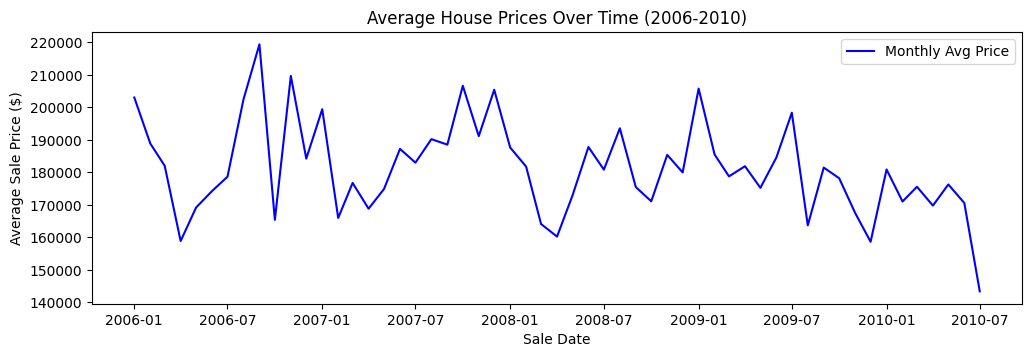

In [30]:
# Visualize trends
plt.figure(figsize=(12, 12))

# Monthly average prices
plt.subplot(3, 1, 1)
plt.plot(monthly_stats['SaleDate'], monthly_stats['SalePrice'], label='Monthly Avg Price', color='blue')
plt.xlabel('Sale Date')
plt.ylabel('Average Sale Price ($)')
plt.title('Average House Prices Over Time (2006-2010)')
plt.legend()
plt.show()

**7.4 YoY Inflation Proxy: Year-over-year percentage change in mean prices.**

In [31]:
# Year-over-year inflation rates to quantify annual price growth
yearly_means = yearly_stats['SalePrice']['mean']
inflation_rates = yearly_means.pct_change() * 100


In [32]:
print("\nYear-over-Year Inflation Rates (%):")
print(inflation_rates)



Year-over-Year Inflation Rates (%):
Yr.Sold
2006         NaN
2007    1.857686
2008   -3.400951
2009    1.433010
2010   -4.854878
Name: mean, dtype: float64


**7.5 Linear Trend: Slope, R², and p-value from a regression of SalePrice on elapsed days.**

In [33]:
# Linear regression to estimate overall price growth rate
time_points = (df_combined['SaleDate'] - df_combined['SaleDate'].min()).dt.days.values
prices = df_combined['SalePrice'].values
slope, intercept, r_value, p_value, std_err = linregress(time_points, prices)

In [34]:
print("\nLinear Trend Slope: ${:.2f} per day".format(slope))
print("R² Value: {:.3f}".format(r_value**2))
print("P-value for Trend: {:.4f}".format(p_value))



Linear Trend Slope: $-4.16 per day
R² Value: 0.001
P-value for Trend: 0.1802


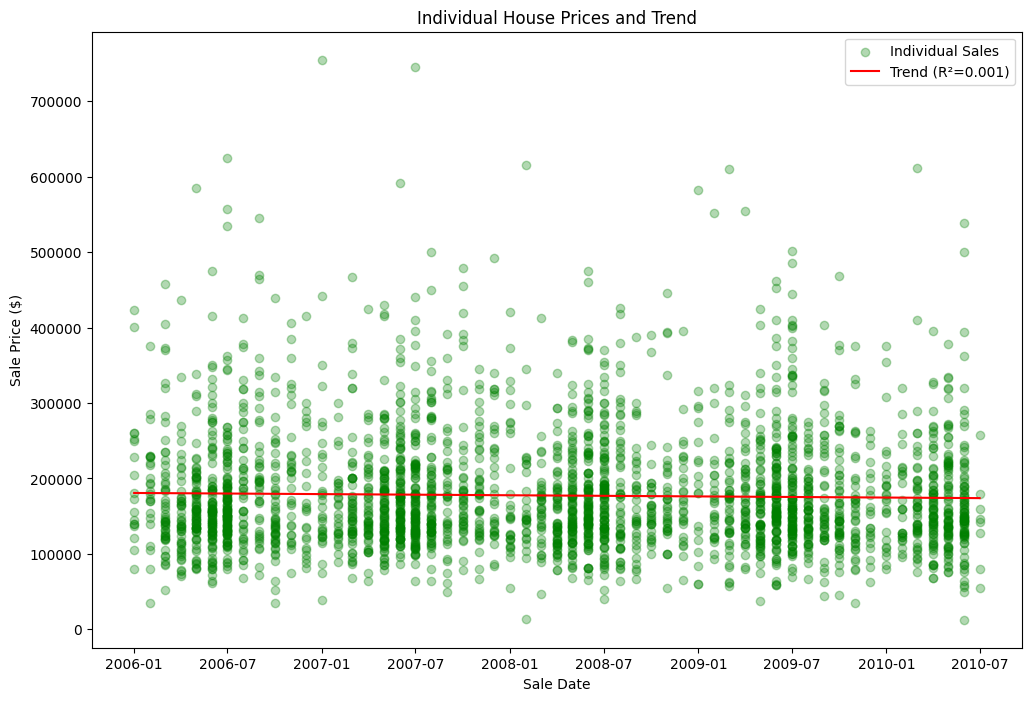

In [35]:
# Individual sales with trend line
plt.figure(figsize=(12, 8))
time_points = (df_combined['SaleDate'] - df_combined['SaleDate'].min()).dt.days
plt.scatter(df_combined['SaleDate'], df_combined['SalePrice'], alpha=0.3, label='Individual Sales', color='green')
trend_line = slope * time_points + df_combined['SalePrice'].mean()
plt.plot(df_combined['SaleDate'], trend_line, label=f'Trend (R²={r_value**2:.3f})', color='red')
plt.xlabel('Sale Date')
plt.ylabel('Sale Price ($)')
plt.title('Individual House Prices and Trend')
plt.legend()
plt.show()

**7.6 Seasonality Plot: Monthly average prices with visible peaks/troughs.**

In [36]:
# Seasonal trends to detect monthly price variations for prediction adjustments
monthly_price_stats = df_combined.groupby('Mo.Sold').agg({
    'SalePrice': ['mean', 'std', 'count']
}).round(2)
monthly_price_stats.columns = ['Mean Price', 'Std Dev', 'Count']


In [37]:
print("\nSeasonal Trends (by Month):")
display(monthly_price_stats)



Seasonal Trends (by Month):


,Mean Price,Std Dev,Count
Mo.Sold,,,
1,194210.02,105421.30,123
2,178364.35,78949.16,133
3,176130.46,83261.85,232
4,167711.99,66342.49,279
5,173700.22,69406.22,395
6,181542.56,78468.36,505
7,184366.86,84335.04,449
8,186222.46,78548.37,233
9,191552.14,86930.67,161


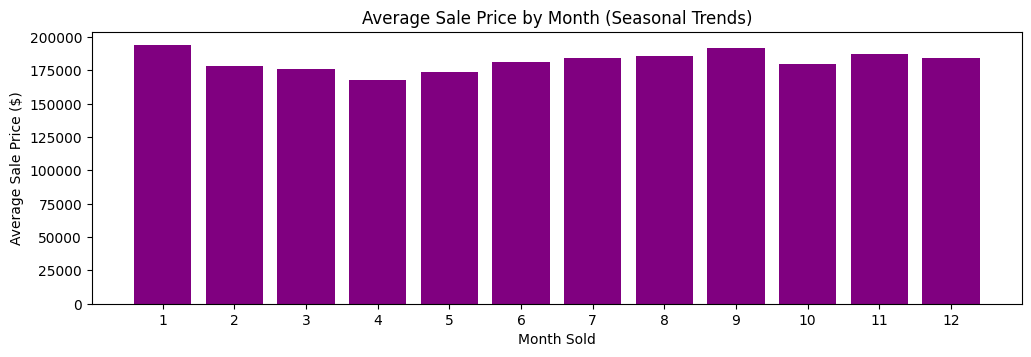

In [38]:
# Seasonal trends
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 3)
plt.bar(monthly_price_stats.index, monthly_price_stats['Mean Price'], color='purple')
plt.xlabel('Month Sold')
plt.ylabel('Average Sale Price ($)')
plt.title('Average Sale Price by Month (Seasonal Trends)')
plt.xticks(range(1, 13))
plt.show()

**7.7. Feature trends over time.** 
- Year-aggregated profiles for `Overall.Qual`, scaled `Gr.Liv.Area` (per 100 sq ft for plotting comparability), and `Year.Built` are visualized. These diagnostics assess whether **compositional changes** in transacted properties (e.g., larger or newer homes) might confound the interpretation of inflation.

In [39]:
# Feature trends over time
yearly_feature_stats = df_combined.groupby('Yr.Sold').agg({
    'Overall.Qual': 'mean',
    'Gr.Liv.Area': 'mean',
    'Year.Built': 'mean'
}).round(2)

In [40]:
print("\nFeature Trends Over Time:")
display(yearly_feature_stats)



Feature Trends Over Time:


,Overall.Qual,Gr.Liv.Area,Year.Built
Yr.Sold,,,
2006,6.09,1509.42,1971.23
2007,6.13,1516.10,1973.01
2008,6.12,1492.26,1969.53
2009,6.13,1503.38,1972.41
2010,5.93,1455.00,1969.56


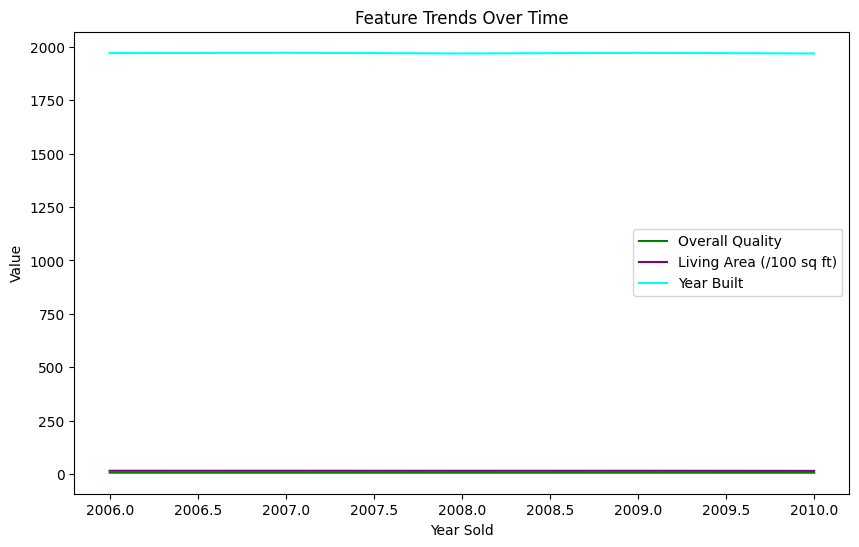

In [41]:
# Feature trends
plt.figure(figsize=(10, 6))
plt.plot(yearly_feature_stats.index, yearly_feature_stats['Overall.Qual'], label='Overall Quality', color='green')
plt.plot(yearly_feature_stats.index, yearly_feature_stats['Gr.Liv.Area'] / 100, label='Living Area (/100 sq ft)', color='purple')
plt.plot(yearly_feature_stats.index, yearly_feature_stats['Year.Built'], label='Year Built', color='cyan')
plt.xlabel('Year Sold')
plt.ylabel('Value')
plt.title('Feature Trends Over Time')
plt.legend()
plt.show()

**7.8. Price volatility.** 
- The **coefficient of variation (CV)** for `SalePrice` is computed by year. Elevated CV implies greater dispersion relative to mean price, potentially indicating market stress or heterogeneous submarket behavior.

In [42]:
# Price volatility (coefficient of variation)
yearly_stats['CV'] = (yearly_stats['SalePrice']['std'] / yearly_stats['SalePrice']['mean'] * 100).round(2)

In [43]:
print("\nPrice Volatility (Coefficient of Variation %):")
print(yearly_stats['CV'])



Price Volatility (Coefficient of Variation %):
Yr.Sold
2006    45.45
2007    44.58
2008    42.27
2009    44.57
2010    43.24
Name: CV, dtype: float64


**7.9 Segmented trend analysis by quality.** 
- The sample is split into **high quality** (`Overall.Qual ≥ 7`) and **lower quality** (`< 7`) segments. Yearly mean prices are plotted for both groups to reveal **differential inflation** or market polarization (premium vs. budget segments). Tabular outputs present the per-year means for transparency.

In [44]:
# Segmented analysis (high vs. low quality)
high_qual = df_combined[df_combined['Overall.Qual'] >= 7]
low_qual = df_combined[df_combined['Overall.Qual'] < 7]
high_qual_yearly = high_qual.groupby('Yr.Sold').agg({'SalePrice': 'mean'}).round(2)
low_qual_yearly = low_qual.groupby('Yr.Sold').agg({'SalePrice': 'mean'}).round(2)

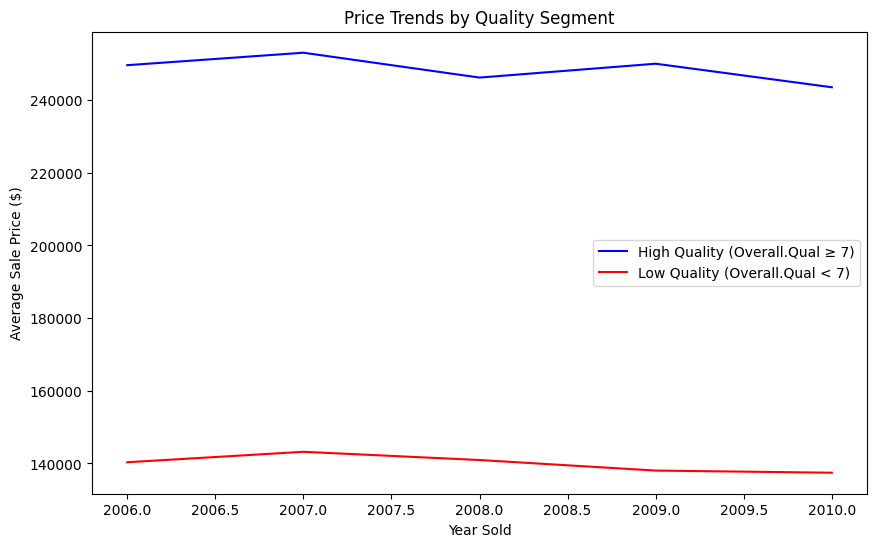

In [45]:
# Segmented trends
plt.figure(figsize=(10, 6))
plt.plot(high_qual_yearly.index, high_qual_yearly['SalePrice'], label='High Quality (Overall.Qual ≥ 7)', color='blue')
plt.plot(low_qual_yearly.index, low_qual_yearly['SalePrice'], label='Low Quality (Overall.Qual < 7)', color='red')
plt.xlabel('Year Sold')
plt.ylabel('Average Sale Price ($)')
plt.title('Price Trends by Quality Segment')
plt.legend()
plt.show()

In [46]:
print("\nHigh Quality (Overall.Qual ≥ 7) Yearly Prices:")
display(high_qual_yearly)



High Quality (Overall.Qual ≥ 7) Yearly Prices:


,SalePrice
Yr.Sold,
2006,249589.24
2007,253020.27
2008,246181.74
2009,249994.20
2010,243520.02


In [47]:
print("\nLow Quality (Overall.Qual < 7) Yearly Prices:")
display(low_qual_yearly)


Low Quality (Overall.Qual < 7) Yearly Prices:


,SalePrice
Yr.Sold,
2006,140330.88
2007,143206.40
2008,140941.86
2009,138039.34
2010,137447.45


**Derived Feature: House Age and Its Association with SalePrice**

A derived feature `House.Age = Yr.Sold − Year.Built` is computed and its correlation with `SalePrice` is reported. Typically, newer homes command higher prices due to modern standards, lower expected maintenance, and updated amenities. A negative correlation magnitude (in absolute terms) suggests that older homes tend to sell for less, controlling only for bivariate association.


In [48]:
# House age effect
df_combined['House.Age'] = df_combined['Yr.Sold'] - df_combined['Year.Built']
age_corr = df_combined[['SalePrice', 'House.Age']].corr().iloc[0, 1].round(2)

In [49]:
print("\nCorrelation of SalePrice with House Age: {:.2f}".format(age_corr))


Correlation of SalePrice with House Age: -0.56


## 8. Prepare data for modeling

In [50]:
# Select highly correlated features (|r| >= 0.5) based on provided output and add house.age
selected_features = [
    'SalePrice',  # Target for prediction
    'Overall.Qual',  # r=0.80, top predictor, house quality
    'Gr.Liv.Area',  # r=0.71, living space size
    'Garage.Cars',  # r=0.65, parking capacity, low missingness (0.14%)
    'Garage.Area',  # r=0.64, garage size, but redundant with Garage.Cars
    'Total.Bsmt.SF',  # r=0.63, basement size, 0.03% missing
    'X1st.Flr.SF',  # r=0.62, main living area
    'Year.Built',  # r=0.56, house age for inflation
    'Full.Bath',  # r=0.55, key amenity, no missing
    'TotRms.AbvGrd',  # r=0.50, room count, no missing
    'Year.Remod.Add',  # r=0.53, remodel year for trends
    'Foundation_PConc',  # r=0.52, categorical, concrete foundation
    'Garage.Yr.Blt',  # r=0.51, garage age, 5.4% missing
    'Mas.Vnr.Area',  # r=0.50, masonry veneer area, 0.8% missing
    'Bsmt.Qual_TA',  # r=-0.50, categorical, typical basement quality
    'Garage.Finish_Unf',  # r=-0.52, categorical, unfinished garage
    'Kitchen.Qual_TA',  # r=-0.53, categorical, typical kitchen quality
    'House.Age',  # r=-0.56, derived, correlates with Year.Built
    'Exter.Qual_TA',  # r=-0.59, categorical, typical exterior quality
]

In [51]:
# Keep only these columns in df_combined
df_combined = df_combined[selected_features]
print("Shape after feature reduction:", df_combined.shape)

Shape after feature reduction: (2930, 19)


In [52]:
# Numerical and categorical feature handling
numerical_cols = ['Overall.Qual', 'Gr.Liv.Area', 'Garage.Cars', 'Garage.Area', 'Total.Bsmt.SF', 
                  'X1st.Flr.SF', 'Year.Built', 'Full.Bath', 'TotRms.AbvGrd', 'Year.Remod.Add', 
                  'Garage.Yr.Blt', 'Mas.Vnr.Area', 'House.Age']
categorical_cols = ['Foundation', 'Bsmt.Qual', 'Garage.Finish', 'Kitchen.Qual', 'Exter.Qual']

In [53]:
# Features and target
X_cols = [col for col in selected_features if col != 'SalePrice']
X = df_combined[X_cols]
y = df_combined['SalePrice']

In [54]:
# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Standardize features (fit on training data only, transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 9. Model Building - Decision Tree Regressor
A decision tree model is trained as a simple and interpretable baseline. Model depth is restricted to prevent overfitting. Performance metrics include RMSE, MAE, and R².

In [56]:
# Decision Tree Model with tuning to reduce overfitting
dt_model = DecisionTreeRegressor(max_depth=3, min_samples_split=15, random_state=42)
dt_model.fit(X_train_scaled, y_train)

y_pred_test_dt = dt_model.predict(X_test_scaled)
test_mse_dt = mean_squared_error(y_test, y_pred_test_dt)
test_rmse_dt = np.sqrt(test_mse_dt)
test_mae_dt = mean_absolute_error(y_test, y_pred_test_dt)
test_r2_dt = r2_score(y_test, y_pred_test_dt)

print(f"Mean Squared Erro: {test_mse_dt:.2f}")
print(f"Root Mean Squared Erro: {test_rmse_dt:.2f}")
print(f"Mean Absolute Erro: {test_mae_dt:.2f}")
print(f"R²: {test_r2_dt:.2f}")

Mean Squared Erro: 2051236268.71
Root Mean Squared Erro: 45290.58
Mean Absolute Erro: 31337.98
R²: 0.67


In [57]:
feature_names = X.columns

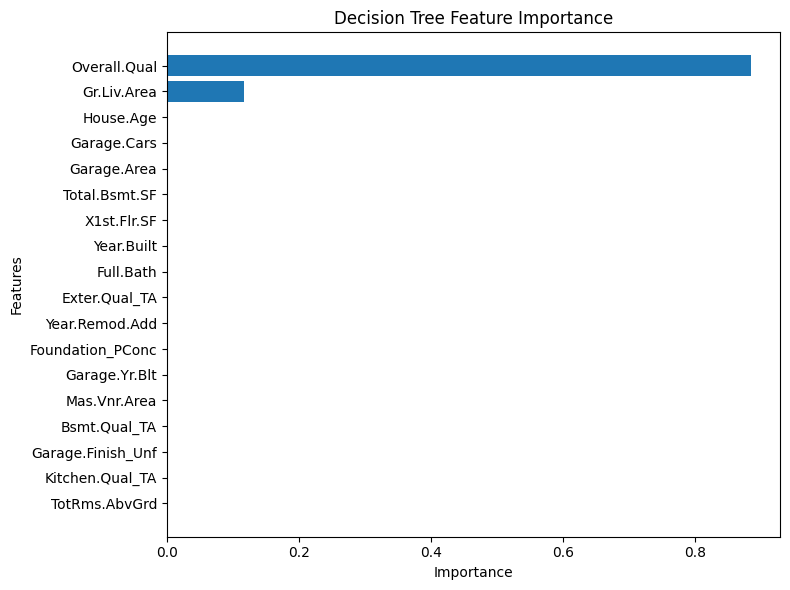

In [58]:
dt_importances = dt_model.feature_importances_
indices_dt = np.argsort(dt_importances)[0::]  
plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_names)), dt_importances[indices_dt])
plt.yticks(range(len(feature_names)), np.array(feature_names)[indices_dt])
plt.title('Decision Tree Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## 10. Model Building - Random Forest Regressor
Random Forest improves upon decision trees by aggregating predictions from multiple estimators. It is more robust and typically achieves better generalization. Performance is evaluated using standard regression metrics

In [59]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Random Forest Evaluation
y_pred_test_rf = rf_model.predict(X_test_scaled)
test_mse_rf = mean_squared_error(y_test, y_pred_test_rf)
test_rmse_rf = np.sqrt(test_mse_rf)
test_mae_rf = mean_absolute_error(y_test, y_pred_test_rf)
test_r2_rf = r2_score(y_test, y_pred_test_rf)

print(f"Mean Squared Error: {test_mse_rf:.2f}")
print(f"Root Mean Squared Error: {test_rmse_rf:.2f}")
print(f"Mean Absolute Error: {test_mae_rf:.2f}")
print(f"R²: {test_r2_rf:.2f}")

Mean Squared Error: 1755171606.78
Root Mean Squared Error: 41894.77
Mean Absolute Error: 19231.80
R²: 0.71


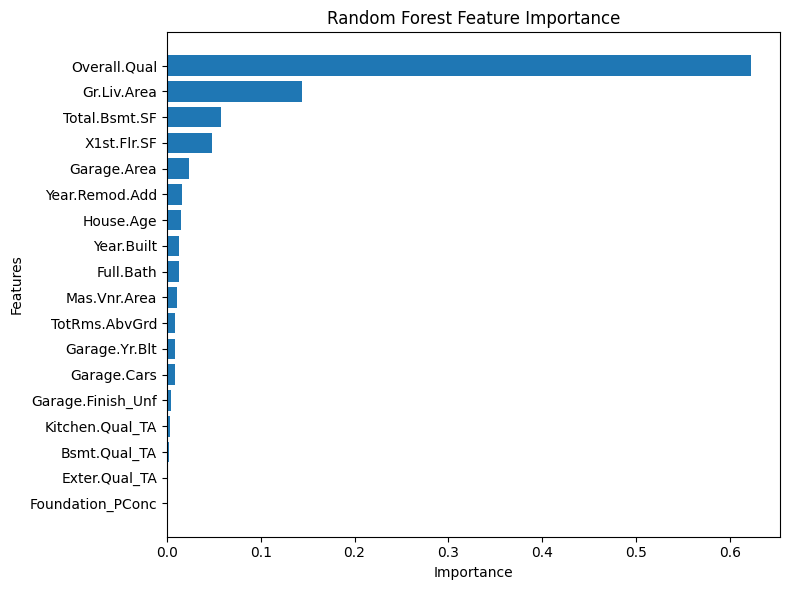

In [60]:
# Random Forest Feature Importance Plot
rf_importances = rf_model.feature_importances_
indices_rf = np.argsort(rf_importances)[0::]
plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_names)), rf_importances[indices_rf])
plt.yticks(range(len(feature_names)), np.array(feature_names)[indices_rf])
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## 11. Model Building - Ridge Regression (From Scratch)
Ridge Regression is implemented using the closed-form solution with L2 regularization. This serves as a baseline linear model and is sensitive to feature scaling. It is useful for understanding the linear relationships in the data.

In [61]:
import numpy as np

class RidgeRegression:
    def __init__(self, alpha=1.0):
        """
        Initialize Ridge Regression model.
        
        Parameters:
        alpha : float, default=1.0
            Regularization strength; must be a positive float.
        """
        self.alpha = alpha
        self.weights = None
        self.bias = None
        
    def fit(self, X, y):
        """
        Fit the Ridge Regression model.
        
        Parameters:
        X : array-like of shape (n_samples, n_features)
            Training data
        y : array-like of shape (n_samples,)
            Target values
            
        Returns:
        self : object
            Returns self.
        """
        # Convert inputs to numpy arrays
        X = np.array(X)
        y = np.array(y)
        
        # Add column of ones for bias term
        X_with_bias = np.c_[X, np.ones(X.shape[0])]
        
        # Calculate weights using closed-form solution:
        # w = (X^T X + alpha*I)^(-1) X^T y
        n_features = X_with_bias.shape[1]
        identity = np.eye(n_features)
        # Don't regularize the bias term
        identity[-1, -1] = 0
        
        # Compute (X^T X + alpha*I)^(-1) X^T y
        XTX = X_with_bias.T @ X_with_bias
        regularized = XTX + self.alpha * identity
        inverse = np.linalg.inv(regularized)
        coefficients = inverse @ X_with_bias.T @ y
        
        # Split coefficients into weights and bias
        self.weights = coefficients[:-1]
        self.bias = coefficients[-1]
        
        return self
    
    def predict(self, X):
        """
        Predict using the Ridge Regression model.
        
        Parameters:
        X : array-like of shape (n_samples, n_features)
            Samples to predict.
            
        Returns:
        y_pred : array-like of shape (n_samples,)
            Predicted values.
        """
        if self.weights is None or self.bias is None:
            raise ValueError("Model must be fitted before prediction")
            
        X = np.array(X)
        return X @ self.weights + self.bias



In [62]:
# Instantiate and fit the model
model = RidgeRegression(alpha=100.0)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate predictions
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Squared Error on test set: {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error on test set: 2184640560.4933
Root Mean Squared Error (RMSE): 46740.1386
R² Score: 0.6443


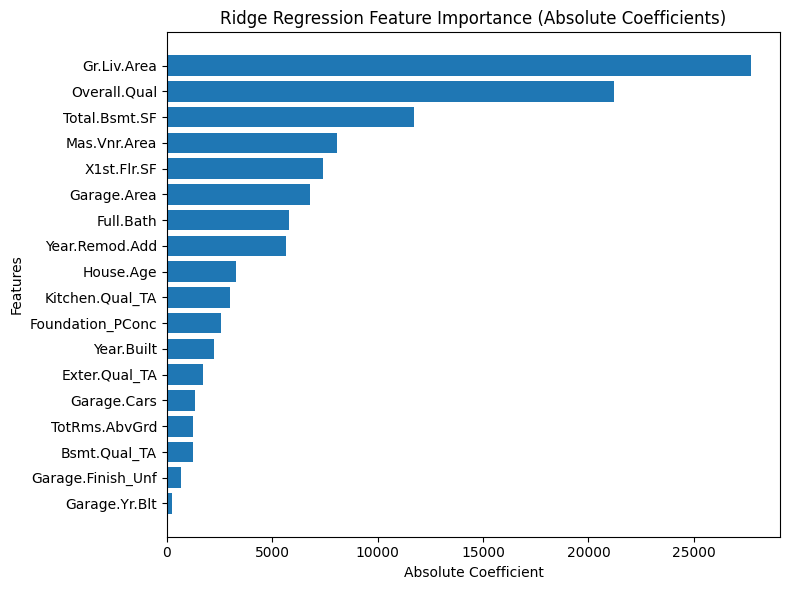

In [63]:
# Ridge Regression Feature Importance Plot (using absolute coefficients)
ridge_coefficients = np.abs(model.weights)
indices_ridge = np.argsort(ridge_coefficients)[0::]
plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_names)), ridge_coefficients[indices_ridge])
plt.yticks(range(len(feature_names)), np.array(feature_names)[indices_ridge])
plt.title('Ridge Regression Feature Importance (Absolute Coefficients)')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## 12. Gradient Boosting Regressor

In [64]:
from sklearn.ensemble import GradientBoostingRegressor
# Gradient Boosting Model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Gradient Boosting Evaluation
y_pred_test_gb = gb_model.predict(X_test_scaled)
test_mse_gb = mean_squared_error(y_test, y_pred_test_gb)
test_rmse_gb = np.sqrt(test_mse_gb)
test_mae_gb = mean_absolute_error(y_test, y_pred_test_gb)
test_r2_gb = r2_score(y_test, y_pred_test_gb)

print("\nAmes Housing - Gradient Boosting:")
print(f"Mean Squared Error: {test_mse_gb:.2f}")
print(f"Root Mean Squared Error: {test_rmse_gb:.2f}")
print(f"Mean Absolute Error: {test_mae_gb:.2f}")
print(f"R²: {test_r2_gb:.2f}")


Ames Housing - Gradient Boosting:
Mean Squared Error: 2154163991.87
Root Mean Squared Error: 46412.97
Mean Absolute Error: 20145.21
R²: 0.65


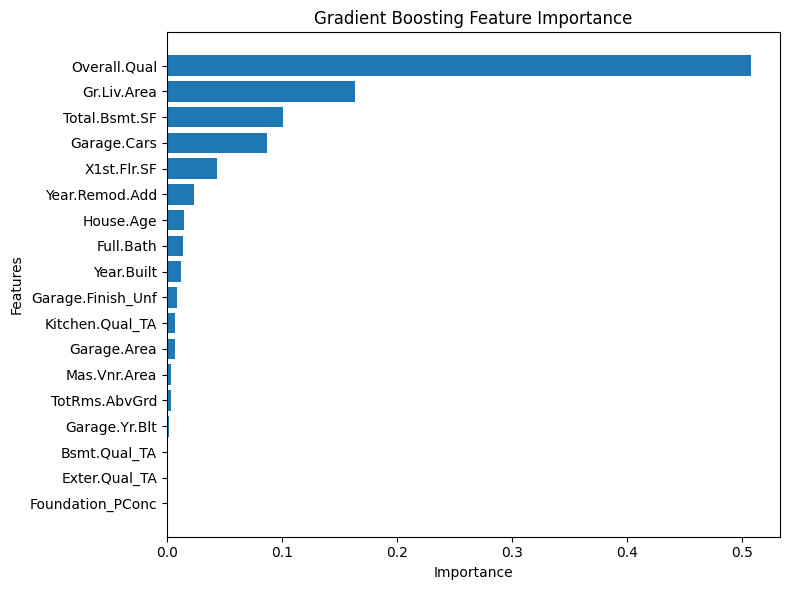

In [65]:
gbt_importances = gb_model.feature_importances_
indices_gbt = np.argsort(gbt_importances)[0::]
plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_names)), gbt_importances[indices_gbt])
plt.yticks(range(len(feature_names)), np.array(feature_names)[indices_gbt])
plt.title('Gradient Boosting Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## Model Comparison
RMSE, MAE, and R² metrics are calculated for all models and compiled into a comparison table. A bar plot is used to visually compare the error metric (R² Score) across models.

In [66]:
# Create comparison DataFrame
data = {
    'Model': ['Decision Tree', 'Random Forest', 'Ridge Regression', 'Gradient Boosting'],
    'MSE': [test_mse_dt, test_mse_rf, mse, test_mse_gb],
    'RMSE': [test_rmse_dt, test_rmse_rf, rmse, test_rmse_gb],
    'MAE': [test_mae_dt, test_mae_rf, mean_absolute_error(y_test, y_pred), test_mae_gb],
    'R²': [test_r2_dt, test_r2_rf, r2, test_r2_gb]
}

comparison_df = pd.DataFrame(data)

# Display the DataFrame
comparison_df

,Model,MSE,RMSE,MAE,R²
0,Decision Tree,2.051236e+09,45290.575937,31337.975983,0.666024
1,Random Forest,1.755172e+09,41894.768251,19231.802928,0.714228
2,Ridge Regression,2.184641e+09,46740.138644,23977.660217,0.644303
3,Gradient Boosting,2.154164e+09,46412.972237,20145.214593,0.649265


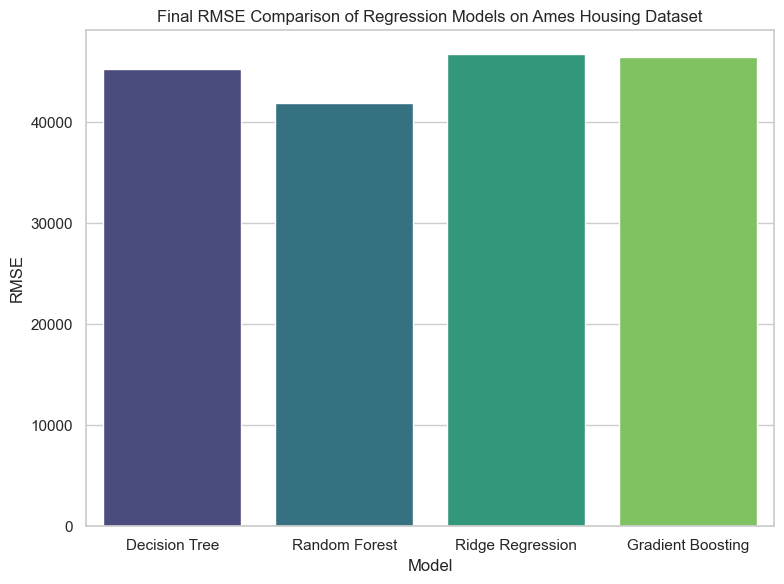

In [67]:
# Final RMSE Comparison Plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract RMSE data from comparison_df
rmse_data = comparison_df[['Model', 'RMSE']].copy()

# Set plot style
sns.set(style='whitegrid')

# Create the RMSE comparison plot
plt.figure(figsize=(8, 6))
sns.barplot(data=rmse_data, x='Model', y='RMSE', palette='viridis')
plt.title('Final RMSE Comparison of Regression Models on Ames Housing Dataset')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.tight_layout()
plt.show()


Text(0.5, 0, 'Model')

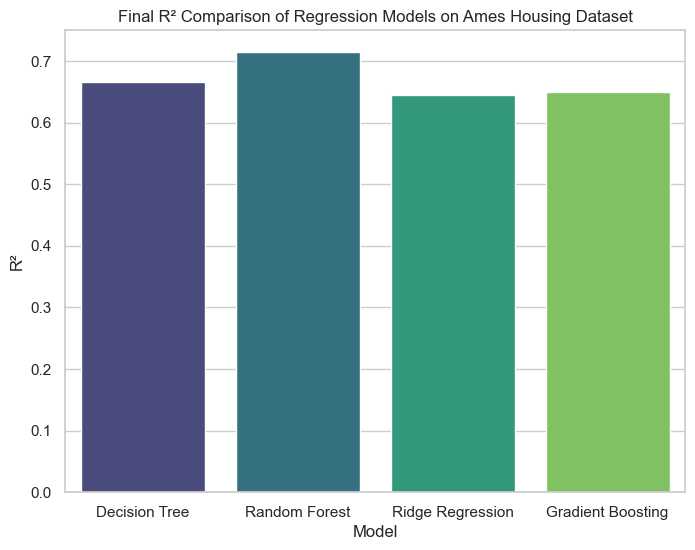

In [68]:
# Extract R² data from comparison_df
r2_data = comparison_df[['Model', 'R²']].copy()

# Set plot style
sns.set(style='whitegrid')

# Create the R² comparison plot
plt.figure(figsize=(8, 6))
sns.barplot(data=r2_data, x='Model', y='R²', palette='viridis')
plt.title('Final R² Comparison of Regression Models on Ames Housing Dataset')
plt.ylabel('R²')
plt.xlabel('Model')

## 12. Interpretation of Results and Conclusion

### Interpretation of Results

- **Random Forest Regressor** yielded the lowest error values across RMSE and MAE, indicating the highest predictive precision among the models:
  - The RMSE of 41,894.77 and MAE of 19,231.80 suggest strong generalization performance with minimal average deviation from actual values.
  - The R² score of 0.714 signifies that the model explains approximately 71.4% of the variance in the target variable, making it the most effective model.

- **Decision Tree Regressor** performed reasonably well but lagged behind Random Forest:
  - With an RMSE of 45,290.58 and MAE of 31,337.98, it shows higher errors, indicating greater sensitivity to data partitions and potential overfitting.
  - The R² score of 0.666 captures about 66.6% of the variance, suggesting moderate predictive power.

- **Gradient Boosting Regressor** showed intermediate performance:
  - With an RMSE of 46,412.97 and MAE of 20,145.21, it performs better than Decision Tree but worse than Random Forest in terms of error metrics.
  - The R² score of 0.649 indicates it explains about 64.9% of the variance, slightly below the other models.

- **Ridge Regression**, despite being a regularized linear model, showed the poorest performance:
  - The highest RMSE (46,740.14) and MAE (23,977.66) reflect the inability of linear models to capture the complex relationships in the dataset.
  - The R² score of 0.644, the lowest among the models, confirms reduced predictive accuracy.

### Conclusion

Based on the comparative analysis of all models, **Random Forest Regressor** is conclusively the best-performing model for the dataset.  
- It offers superior accuracy, with the lowest RMSE (41,894.77) and MAE (19,231.80), and the highest explanatory power (R² = 0.714), making it the optimal choice for deployment or downstream tasks.

- **Decision Tree Regressor** may serve as a simplified baseline or interpretable approximation, though its higher errors suggest it’s less reliable than ensemble methods.

- **Gradient Boosting Regressor** provides a reasonable alternative but falls short of Random Forest, suitable for scenarios where additional tuning might improve performance.

- **Ridge Regression** should be retained only as a linear interpretability benchmark, given its lower performance across all metrics.